# ReAct method

This notebook aims at evaluating the **ReAct method**.

**ReAct** method basically consists in re-using existing logit-based OOD methods, but with penultimate layer **activations clipped** to a certain threshold value. In practice, this threshold is set based on the $p$-th percentile of penultimate activations estimated on the ID data.

Here, we focus on a toy convolutional network trained on MNIST[0-4] challenged on MNIST[5-9].

**Reference**  
_React: Out-of-distribution detection with rectified activations._  
Sun, Yiyou, Chuan Guo, and Yixuan Li.  
Advances in Neural Information Processing Systems 34 (2021)  
<https://arxiv.org/pdf/2111.12797.pdf>


### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from IPython.display import clear_output
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import torch

from oodeel.methods import MLS, Energy, Entropy, ODIN
from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features
from oodeel.datasets import OODDataset
from oodeel.utils.torch_training_tools import train_torch_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Note that models are saved at *~/.oodeel/saved_models* and data is supposed to be found
at *~/.oodeel/datasets* by default. Change the following cell for a custom path.

In [2]:
model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## MNIST[0-4] vs MNIST[5-9]

We train a toy convolutional network on the MNIST dataset restricted to digits 0 to 4. After fitting the train subset of this dataset to different OOD methods with react option enabled, we will compare the scores returned for MNIST[0-4] (in-distrubtion) and MNIST[5-9] (out-of-distribution) test subsets.

### Data loading

* In-distribution data: MNIST[0-4]
* Out-of-distribution data: MNIST[5-9]

> **Note:** We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD) data
with `_out` to avoid confusion with OOD detection which is the name of the task, and is
therefore used to denote core classes such as `OODDataset` and `OODBaseDetector`.

In [3]:
# === load ID and OOD data ===
batch_size = 128
in_labels = [0, 1, 2, 3, 4]

# 1- load train/test MNIST dataset
mnist_train = OODDataset(
    dataset_id='MNIST', backend="torch",
    load_kwargs={"root": data_path, "train": True, "download": True}
)
mnist_test = OODDataset(
    dataset_id='MNIST', backend="torch",
    load_kwargs={"root": data_path, "train": False, "download": True}
)

# 2- split ID / OOD data depending on label value:
# in-distribution: MNIST[0-4] / out-of-distribution: MNIST[5-9]
oods_fit, _ = mnist_train.split_by_class(in_labels=in_labels)
oods_in, oods_out = mnist_test.split_by_class(in_labels=in_labels)

# 3- prepare data (preprocess, shuffle, batch) => torch dataloaders
def preprocess_fn(inputs):
    """Simple preprocessing to normalize images in [0, 1].
    """
    x = inputs[0] / 255.0
    return tuple([x] + list(inputs[1:]))

ds_fit = oods_fit.prepare(
    batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True
)
ds_in = oods_in.prepare(
    batch_size=batch_size, with_ood_labels=False, preprocess_fn=preprocess_fn
)
ds_out = oods_out.prepare(
    batch_size=batch_size, with_ood_labels=False, preprocess_fn=preprocess_fn
)

clear_output()

### Model training

Now let's train a simple model on MNIST[0-4] using `train_torch_model` function.

In [4]:
# === Train / Load model ===
# model path
model_path_mnist_04 = os.path.join(model_path, "mnist_model_0-4")

try:
    # if the model exists, load it
    model = torch.load(os.path.join(model_path_mnist_04, "best.pt")).to(device)
except OSError:
    # else, train a new model
    train_config = {
        "model": "toy_convnet",
        "num_classes": 10,
        "epochs": 5,
        "save_dir": model_path_mnist_04,
        "validation_data": ds_in
    }
    model = train_torch_model(ds_fit, **train_config).to(device)
    clear_output()

# evaluate model
model.eval()
labels, preds = [], []
for (x, y) in ds_in:
    x = x.to(device)
    preds.append(torch.argmax(model(x), dim=-1).detach().cpu())
    labels.append(y)
print(f"Test accuracy:\t{accuracy_score(torch.cat(labels), torch.cat(preds)):.6f}")

# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

TypeError: preprocess_fn() takes 1 positional argument but 2 were given

### ReAct scores

We now fit some OOD detectors using ReAct + [MLS, MSP, Energy, Entropy, ODIN] with MNIST[0-4] train dataset, and compare OOD scores returned for MNIST[0-4] (ID) and MNIST[5-9] (OOD) test datasets.

=== ODIN ===
~ Without react ~
auroc      0.786271
fpr95tpr   0.631640


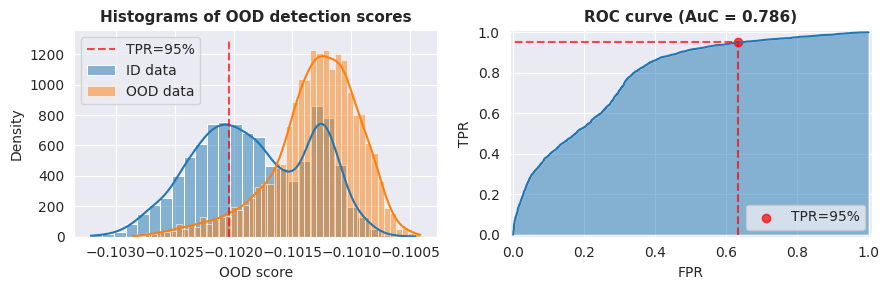

~ With react ~
auroc      0.818530
fpr95tpr   0.461374


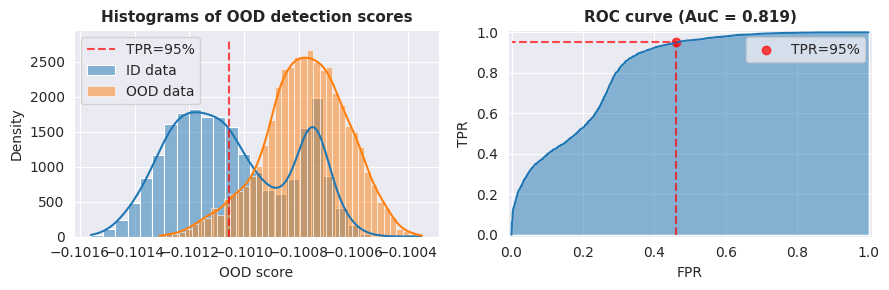

=== MLS ===
~ Without react ~
auroc      0.896637
fpr95tpr   0.514886


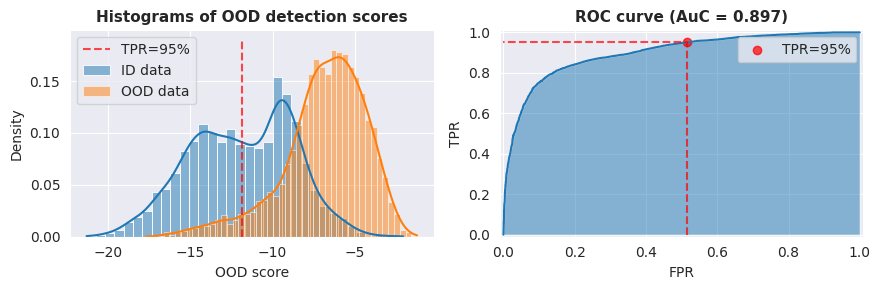

~ With react ~
auroc      0.937103
fpr95tpr   0.338198


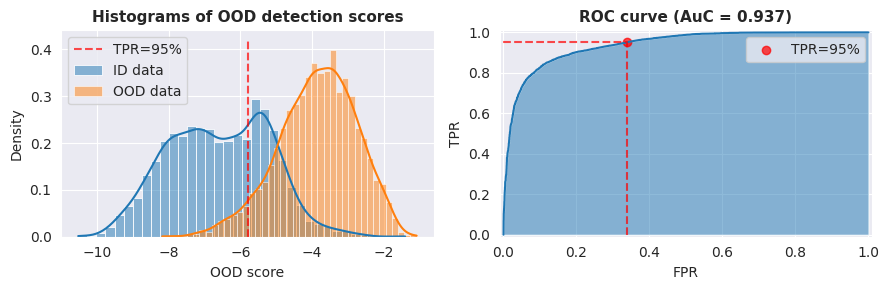

=== MSP ===
~ Without react ~
auroc      0.907393
fpr95tpr   0.616073


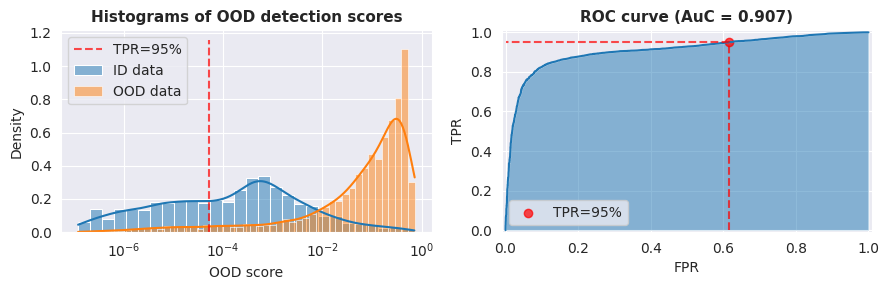

~ With react ~
auroc      0.939360
fpr95tpr   0.354544


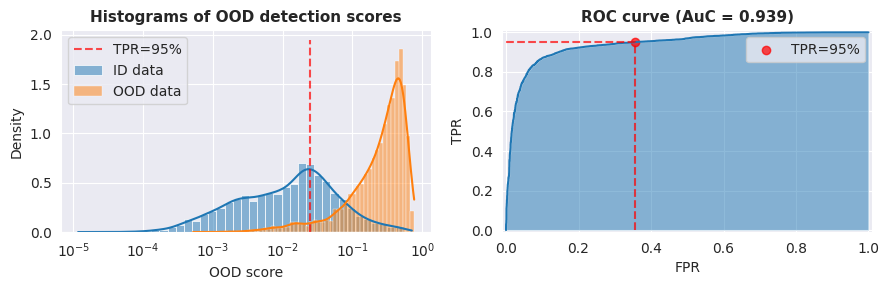

=== ENERGY ===
~ Without react ~
auroc      0.893417
fpr95tpr   0.514886


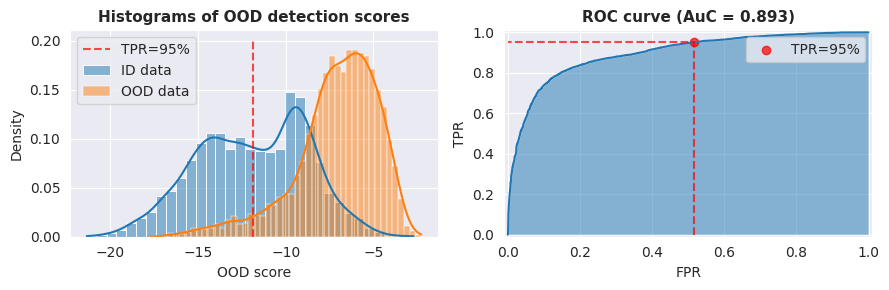

~ With react ~
auroc      0.930291
fpr95tpr   0.340144


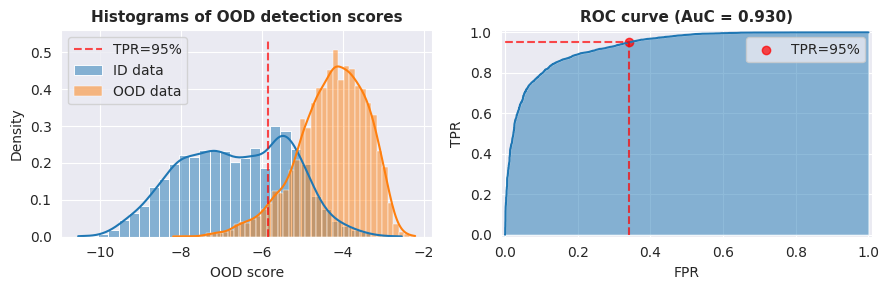

=== ENTROPY ===
~ Without react ~
auroc      0.907685
fpr95tpr   0.616852


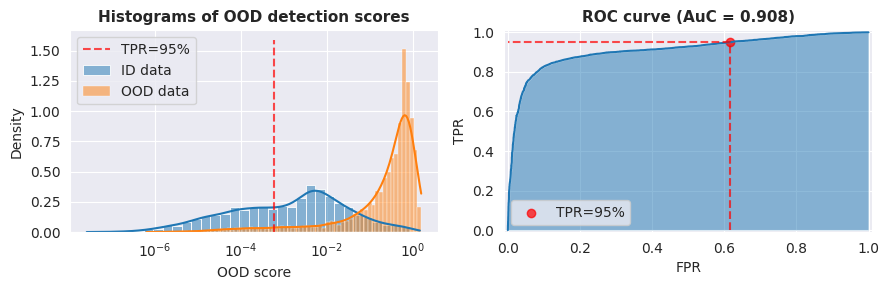

~ With react ~
auroc      0.939739
fpr95tpr   0.362327


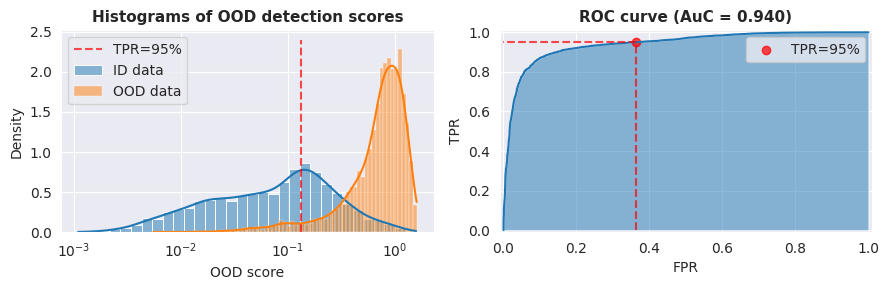

In [ ]:
detectors = {
    "odin": {
        "class": ODIN,
        "kwargs": dict(temperature=1000),
    },
    "mls": {
        "class": MLS,
        "kwargs": dict(),
    },
    "msp": {
        "class": MLS,
        "kwargs": dict(output_activation="softmax"),
    },
    "energy": {
        "class": Energy,
        "kwargs": dict(),
    },
    "entropy": {
        "class": Entropy,
        "kwargs": dict(),
    },
}

for d in detectors.keys():
    print(f"=== {d.upper()} ===")

    for use_react in [False, True]:
        print(["~ Without", "~ With"][int(use_react)] + " react ~")
        # === ood scores ===
        d_kwargs = detectors[d]["kwargs"]
        d_kwargs.update(dict(
            use_react=use_react,
            react_quantile=0.8,
        ))
        detector = detectors[d]["class"](**d_kwargs)
        detector.fit(model, fit_dataset=ds_fit)
        scores_in, _ = detector.score(ds_in)
        scores_out, _ = detector.score(ds_out)

        # === metrics ===
        # auroc / fpr95
        metrics = bench_metrics(
            (scores_in, scores_out),
            metrics=["auroc", "fpr95tpr"],
        )
        for k, v in metrics.items():
            print(f"{k:<10} {v:.6f}")

        log_scale = d in ["msp", "entropy"]
        # hists / roc
        plt.figure(figsize=(9, 3))
        plt.subplot(121)
        if d == "msp":
            # Normalize scores for a better hist visualization
            minim = np.min([np.min(scores_in), np.min(scores_out)])
            scores_in_ = scores_in - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
            scores_out_ = scores_out - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
            plot_ood_scores(scores_in_, scores_out_, log_scale=log_scale)
        else:
            plot_ood_scores(scores_in, scores_out, log_scale=log_scale)
        plt.subplot(122)
        plot_roc_curve(scores_in, scores_out)
        plt.tight_layout()
        plt.show()